# Version 1
This notebook will show how the version1 dataset have been generated.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
import json
warnings.filterwarnings('ignore')

In [2]:
training = "../../data/train.csv"
test = "../../data/test.csv"

In [3]:
df_train = pd.read_csv(training)
df_test = pd.read_csv(test)

In [4]:
# remove outliers
df_train = df_train[df_train.GrLivArea < 4000]

In [5]:
def fillzero(data, columns):
    for t in columns:
        data[t].fillna(0, inplace=True)

In [6]:
def logtransform(data, columns):
    for n in columns:
        data[n] = np.log1p(data[n].values)

In [7]:
def fillcat(data, columns):
    for c in columns:
        data[c] = data[c].astype('category')
        if data[c].isnull().any():
            data[c] = data[c].cat.add_categories(['MISSING'])
            data[c] = data[c].fillna('MISSING')

In [8]:
def encode(train,test, feature):
    ordering = pd.DataFrame()
    ordering['val'] = train[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = train[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        train.loc[train[feature] == cat, feature+'_E'] = o
        test.loc[test[feature] == cat, feature+'_E'] = o

In [9]:
# filling baths 
bathcols = ["FullBath", "BsmtFullBath", "HalfBath", "BsmtHalfBath"]
fillzero(df_train, bathcols)
fillzero(df_test, bathcols)

In [10]:
df_train["totalBaths"] = df_train["FullBath"] + df_train["BsmtFullBath"] + 0.5 *(df_train["HalfBath"] + df_train["BsmtHalfBath"])
df_test["totalBaths"] = df_test["FullBath"] + df_test["BsmtFullBath"] + 0.5 *(df_test["HalfBath"] + df_test["BsmtHalfBath"])

In [11]:
#GarageCars
cars = ["GarageCars"]
fillzero(df_train, cars)
fillzero(df_test, cars)

In [12]:
#Aging
df_train["Aging"] = df_train["YrSold"] - df_train["YearBuilt"]
df_test["Aging"] = df_test["YrSold"] - df_test["YearBuilt"]

In [13]:
#Total Floor
df_train["FloorSF"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"]
df_test["FloorSF"] = df_test["1stFlrSF"] + df_test["2ndFlrSF"]

In [14]:
#Total Area
Bsmt = ["TotalBsmtSF"]
fillzero(df_train, Bsmt)
fillzero(df_test, Bsmt)

In [15]:
df_train["totalArea"] = df_train["GrLivArea"] + df_train["TotalBsmtSF"]
df_test["totalArea"] = df_test["GrLivArea"] + df_test["TotalBsmtSF"]

In [16]:
# Total Grade
df_train["totalGrade"] = df_train["totalArea"] * df_train["OverallQual"]
df_test["totalGrade"] = df_test["totalArea"] * df_test["OverallQual"]

In [17]:
cat = ["Neighborhood", "BsmtQual", "ExterQual", "KitchenQual"]
fillcat(df_train, cat)
fillcat(df_test, cat)
for c in cat:
    encode(df_train, df_test, c)

In [18]:
features = ["GarageCars", "totalBaths", "YearBuilt", "FloorSF", "totalArea", "totalGrade", "Neighborhood_E",
           "ExterQual_E", "BsmtQual_E", "KitchenQual_E"]

In [19]:
train_X = df_train[features]
test_X = df_test[features]

In [20]:
y = np.log1p(df_train["SalePrice"])

In [21]:
print(train_X.shape)
print(test_X.shape)
print(y.shape)

(1456, 10)
(1459, 10)
(1456,)


In [22]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)

In [23]:
train_X.mean(axis=0)

array([  6.58813663e-17,  -2.51325212e-16,  -9.91880570e-16,
         2.95856136e-17,   8.41817458e-17,  -1.09802277e-16,
        -4.27008856e-18,  -2.87315959e-16,  -2.68405566e-16,
        -2.70845617e-16])

In [24]:
train_X.std(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [25]:
test_X["KitchenQual_E"].fillna(0, inplace=True)

In [26]:
test_X = scaler.transform(test_X)

In [27]:
test_X.mean(axis=0)

array([ 0.00064936,  0.02765484,  0.00570827, -0.03687116, -0.03382242,
       -0.01671163, -0.04054726,  0.00940725, -0.01800015,  0.00153458])

In [28]:
test_X.std(axis=0)

array([ 1.04133065,  1.06900189,  1.00624147,  0.98622056,  1.03583176,
        1.05627701,  1.01913918,  1.0284795 ,  1.06361158,  1.0058234 ])

In [29]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

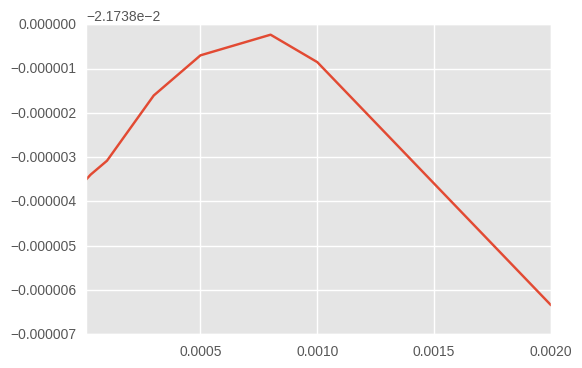

In [30]:
from sklearn.linear_model import Lasso
alphas = [1e-5,3e-5,1e-4,3e-4,5e-4,8e-4, 1e-3, 2e-3]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), train_X, y) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [31]:
model = Lasso(alpha = 8e-4, max_iter =  50000).fit(train_X, y)

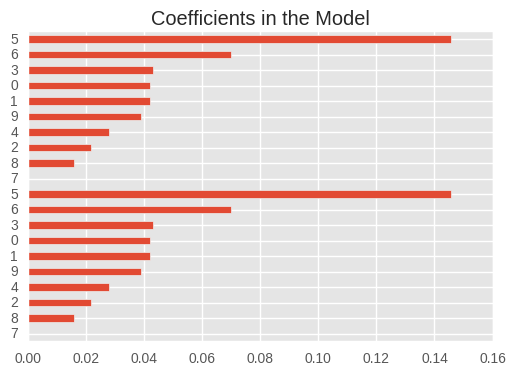

In [32]:
coef = pd.Series(model.coef_, index = pd.DataFrame(train_X).columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

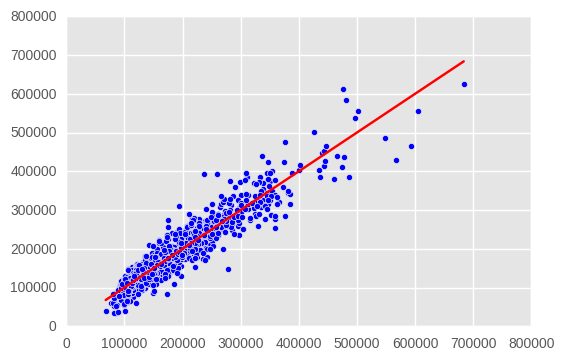

In [33]:
p_pred = np.expm1(model.predict(train_X))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")

In [34]:
p = np.expm1(model.predict(test_X))
solution = pd.DataFrame({"id":df_test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../../data/submission/version1-test.csv", index = False)